### Look at relationship between choice and preference decoders for some feature
- First pass: Just look at cosine similarity
- Specifically, look at whether the preference decoder axis aligns with the choice axis during 800ms of card fixation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy
from tqdm import tqdm

In [7]:
def load_weights(args):
    args = copy.deepcopy(args)
    if args.mode == "pref":
        args.sig_unit_level = "pref_99th_window_filter_drift"
        args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
    else: 
        args.base_output_path = "/data/patrick_res/choice_reward"
        args.sig_unit_level = "choice_99th_window_filter_drift"
    res = []
    for feat in FEATURES:
        args.feat = feat
        weights = belief_partitions_io.get_weights(args)
        weights["Time_milli"] = (weights["Time"] * 1000).astype(int)
        weights["feat"] = feat
        res.append(weights)
    return pd.concat(res)


def compute_for_feats(args):
    res = []
    for feat in FEATURES:
        args.feat = feat
        try: 
            pref_args = copy.deepcopy(args)
            pref_args.sig_unit_level = "pref_99th_window_filter_drift"
            pref_args.beh_filters = {"Response": "Correct", "Choice": "Chose"}

            pref_args.mode = "pref"
            pref_weights = belief_partitions_io.get_weights(pref_args)
            pref_weights["Time_milli"] = (pref_weights["Time"] * 1000).astype(int)

            choice_args = copy.deepcopy(args)
            choice_args.base_output_path = "/data/patrick_res/choice_reward"
            choice_args.sig_unit_level = "choice_99th_window_filter_drift"
            choice_args.mode = "choice"

            # choice_args.mode = "choice"

            choice_weights = belief_partitions_io.get_weights(choice_args)  
            choice_weights["Time_milli"] = (choice_weights["Time"] * 1000).astype(int)
        except Exception as e: 
            if args.shuffle_idx is None:
                raise e
            else: 
                print(f"Can't find {args.feat}, {args.shuffle_idx}")
                continue

        merged = pd.merge(choice_weights, pref_weights, on="PseudoUnitID", suffixes=("_choice", "_pref"), how="outer").fillna(0)
        # sims = merged.groupby(["Time_choice", "Time_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_choice, x.weightsdiff_pref)).reset_index(name="cosine_sim")
        sims = merged.groupby(["Time_milli_choice", "Time_milli_pref"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_normed_choice, x.weightsdiff_normed_pref)).reset_index(name="cosine_sim")
        sims["feat"] = feat
        res.append(sims)
    res = pd.concat(res)
    return res


def load_pref_and_compute(args, choice_weights):
    pref_weights = load_weights(args)
    merged = pd.merge(choice_weights, pref_weights, on=["PseudoUnitID", "feat"], suffixes=("_choice", "_pref"), how="outer").fillna(0)
    sims = merged.groupby(["Time_milli_choice", "Time_milli_pref", "feat"]).apply(lambda x: classifier_utils.cosine_sim(x.weightsdiff_normed_choice, x.weightsdiff_normed_pref)).reset_index(name="cosine_sim")
    sims["Time"] = sims["Time_milli_pref"] / 1000
    return sims


### Load pref weights for stim, fb, choice weights for fb. 

/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


shuffle 4 not found
shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


shuffle 8 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found
shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))


shuffle 8 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found
shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found
shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 8 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 8 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found
shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

shuffle 4 not found
shuffle 5 not found


/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encountered in scalar divide
  return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))
/src/wcst_decode/utils/classifier_utils.py:362: RuntimeWarning: invalid value encount

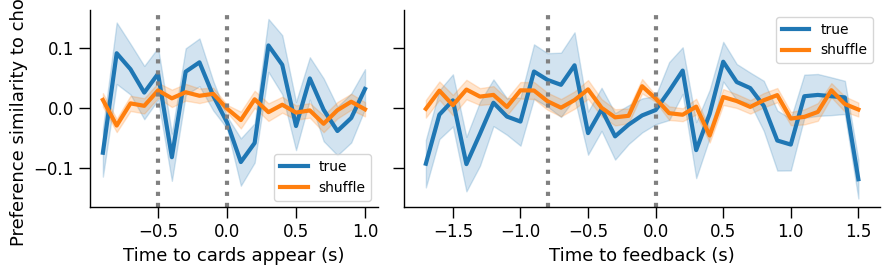

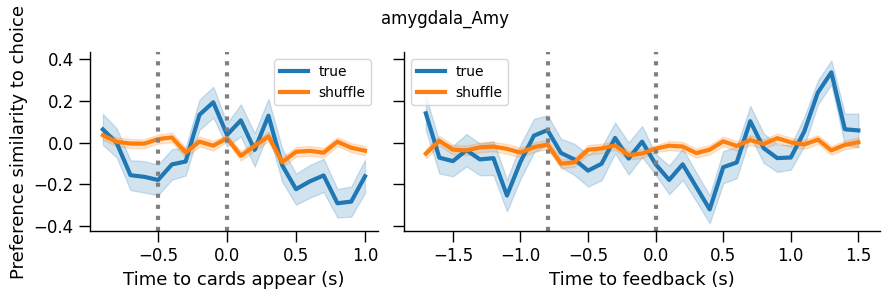

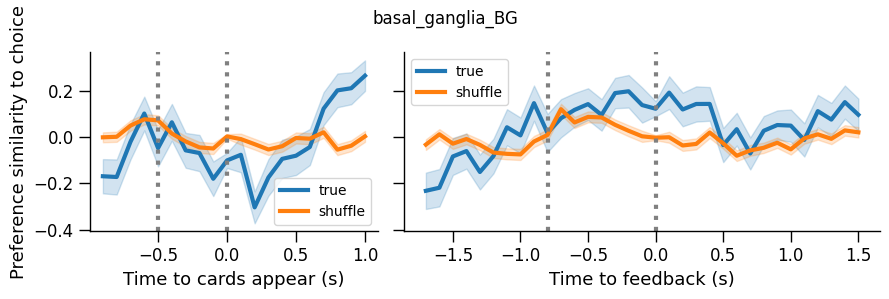

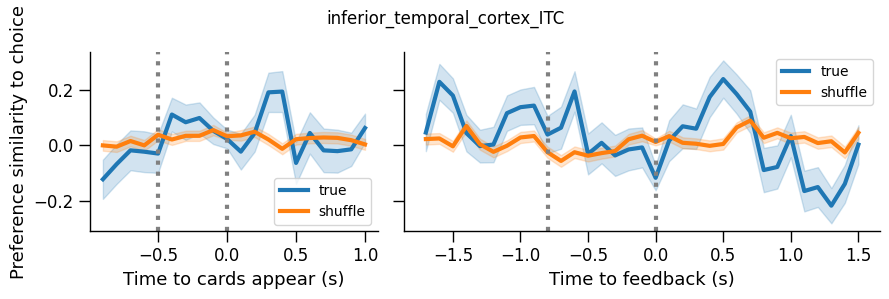

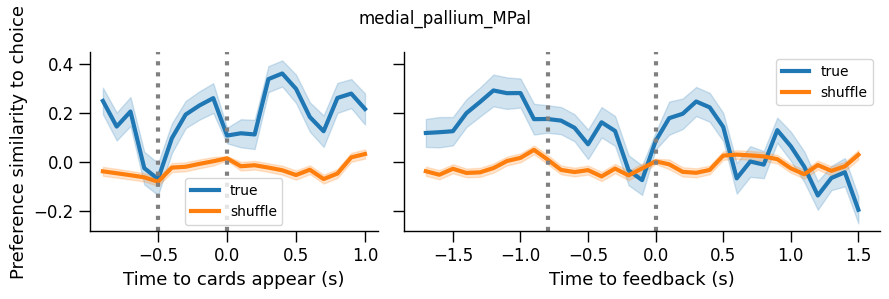

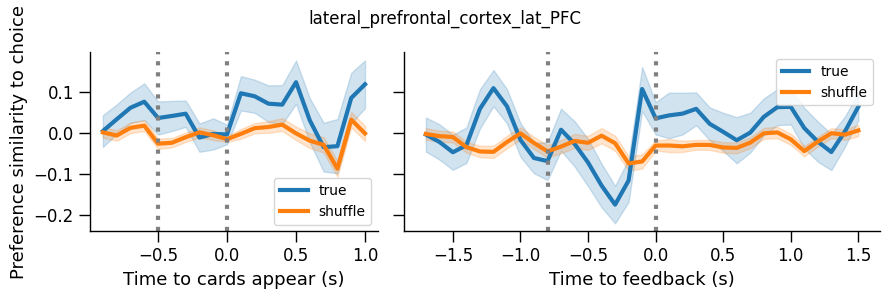

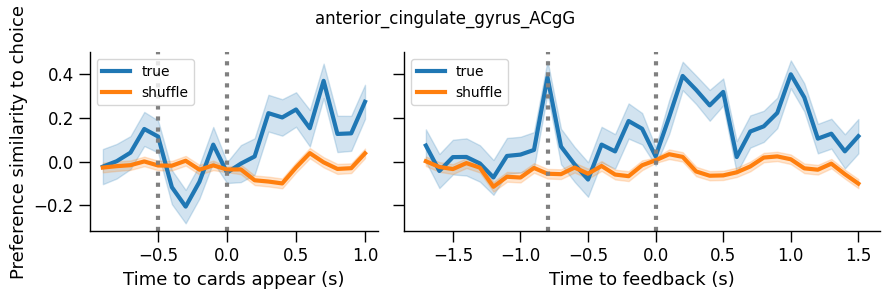

In [8]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.subject = "both"

REGIONS = [None, "amygdala_Amy", "basal_ganglia_BG", "inferior_temporal_cortex_ITC", "medial_pallium_MPal", "lateral_prefrontal_cortex_lat_PFC", "anterior_cingulate_gyrus_ACgG"]

for region in REGIONS: 
    args.regions = region
    args.region_level = "structure_level2_cleaned" if region else None
    args.trial_event = "FeedbackOnsetLong"
    args.mode = "choice"
    choice_weights = load_weights(args)
    choice_weights = choice_weights[(choice_weights.Time_milli > -800) & (choice_weights.Time_milli < 0)]

    fig, axs = plt.subplots(1, 2, width_ratios=(20, 33), figsize=(9, 3), sharey=True)

    for i, event in enumerate(["StimOnset", "FeedbackOnsetLong"]):
        args.trial_event = event
        args.mode = "pref"

        sims = load_pref_and_compute(args, choice_weights)

        all_shuffles = []
        shuf_args = copy.deepcopy(args)
        for shuffle_idx in range(10):
            shuf_args.shuffle_idx = shuffle_idx
            try: 
                shuffle_sims = load_pref_and_compute(shuf_args, choice_weights)
                shuffle_sims["shuffle_idx"] = shuffle_idx
                all_shuffles.append(shuffle_sims)
            except FileNotFoundError as e:
                print(f"shuffle {shuffle_idx} not found")
                
        all_shuffles = pd.concat(all_shuffles).fillna(0)
        
        sns.lineplot(sims, x="Time", y="cosine_sim", errorbar="se", ax=axs[i], label="true", linewidth=3)
        sns.lineplot(all_shuffles, x="Time", y="cosine_sim", errorbar="se", ax=axs[i], label="shuffle", linewidth=3)

    axs[0].axvline(-.5, color='grey', linestyle='dotted', linewidth=3)
    axs[0].axvline(0, color='grey', linestyle='dotted', linewidth=3)
    axs[0].set_xlabel(f"Time to cards appear (s)")
    axs[0].set_ylabel(f"Preference similarity to choice")

    axs[1].set_xlabel(f"Time to feedback (s)")
    axs[1].axvline(-.8, color='grey', linestyle='dotted', linewidth=3)
    axs[1].axvline(0, color='grey', linestyle='dotted', linewidth=3)
    visualization_utils.format_plot(axs)
    fig.suptitle(region)
    fig.tight_layout()    



### Older scrap

In [28]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.subject = "both"
# args.region_level = "structure_level2_cleaned"
# args.regions = "lateral_prefrontal_cortex_lat_PFC"
# args.regions = "inferior_temporal_cortex_ITC"
# args.regions = "medial_pallium_MPal"
# args.regions = "basal_ganglia_BG"
# args.regions = "amygdala_Amy"


res = compute_for_feats(args)
avg_res = res.groupby(["Time_milli_choice", "Time_milli_pref"]).mean("cosine_sim").reset_index()

In [29]:
card_fix_times = avg_res[(avg_res.Time_milli_choice >= -800) & (avg_res.Time_milli_choice < 0)]


<Axes: xlabel='Time_milli_pref', ylabel='cosine_sim'>

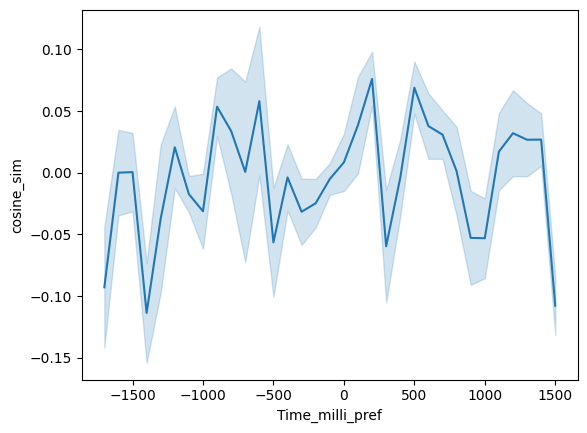

In [30]:
sns.lineplot(card_fix_times, x="Time_milli_pref", y="cosine_sim", errorbar="se")


In [21]:
all_shuffle_res = []
for shuffle_idx in tqdm(range(10)):
    shuffle_args = copy.deepcopy(args)
    shuffle_args.shuffle_idx = shuffle_idx
    shuffle_res = compute_for_feats(shuffle_args)
    shuffle_res["shuffle_idx"] = shuffle_idx
    all_shuffle_res.append(shuffle_res)
all_shuffle_res= pd.concat(all_shuffle_res)

 50%|█████     | 5/10 [00:22<00:22,  4.53s/it]

Can't find CIRCLE, 5


 50%|█████     | 5/10 [00:26<00:26,  5.39s/it]


KeyboardInterrupt: 

In [12]:
all_shuffle_res

,Time_choice,Time_pref,cosine_sim,feat,shuffle_idx
0,-1.7,-1.7,-0.054159,CIRCLE,0
1,-1.7,-1.6,0.036197,CIRCLE,0
2,-1.7,-1.5,0.074669,CIRCLE,0
3,-1.7,-1.4,0.163751,CIRCLE,0
4,-1.7,-1.3,0.205754,CIRCLE,0
...,...,...,...,...,...
1084,1.5,1.1,0.292816,SWIRL,9
1085,1.5,1.2,0.405800,SWIRL,9
1086,1.5,1.3,0.393680,SWIRL,9
1087,1.5,1.4,0.390355,SWIRL,9


<Axes: xlabel='Time_choice', ylabel='Time_pref'>

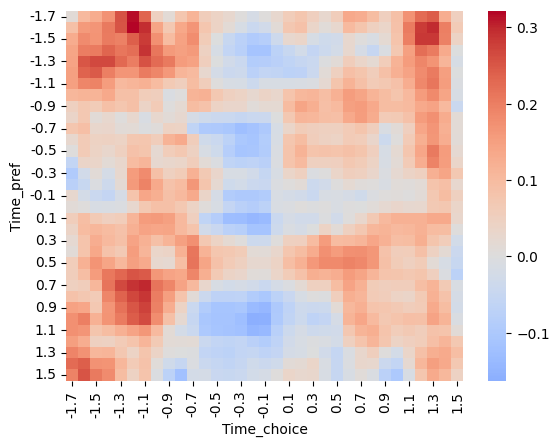

In [13]:
pivoted = avg_res.pivot(index="Time_pref", columns="Time_choice", values="cosine_sim")
sns.heatmap(pivoted, cmap='coolwarm', center=0)

In [14]:
match_res = res[res.Time_choice == res.Time_pref]
shuffle_match_res = all_shuffle_res[all_shuffle_res.Time_choice == all_shuffle_res.Time_pref]


In [15]:
match_res

,Time_choice,Time_pref,cosine_sim,feat
0,-1.7,-1.7,-0.375217,CIRCLE
34,-1.6,-1.6,0.037070,CIRCLE
68,-1.5,-1.5,-0.003593,CIRCLE
102,-1.4,-1.4,0.063754,CIRCLE
136,-1.3,-1.3,0.420557,CIRCLE
...,...,...,...,...
952,1.1,1.1,-0.338235,SWIRL
986,1.2,1.2,-0.460412,SWIRL
1020,1.3,1.3,-0.357060,SWIRL
1054,1.4,1.4,-0.411477,SWIRL


<Axes: xlabel='Time_choice', ylabel='cosine_sim'>

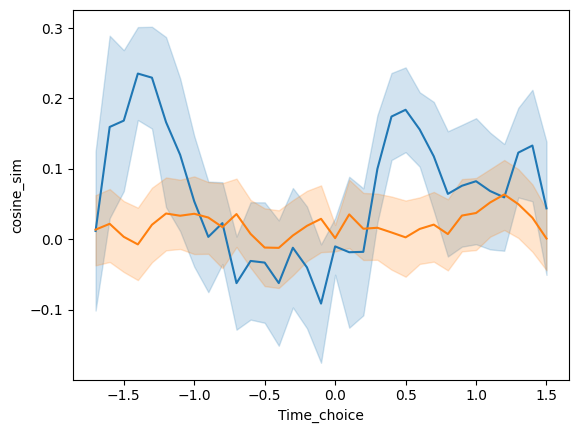

In [16]:
fig, ax = plt.subplots()
sns.lineplot(match_res, x="Time_choice", y="cosine_sim", errorbar="se", ax=ax)
sns.lineplot(shuffle_match_res, x="Time_choice", y="cosine_sim", errorbar="ci", ax=ax)


res